In [81]:
#use niwrap2912 conda environment
# Import required libraries
import numpy as np
import nibabel as nib
from scipy.ndimage import map_coordinates
import os
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore

# Configuration
#for exvivo (bigbrain stuff is on the next cell!)
base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_960um_dist_method0'
workbench_base_path ='/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm'
manual_base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm'
output_dir = './figure'
hemi = 'rh'
fontsize = 8
percentil_low = 20
percentil_high = 80
cmap = 'plasma'
resolutions = ['120', '240']
data_types = ['raw', 'raw_zscore', 'diff', 'diff_zscore']

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all subject folders
subject_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
print(f"Found {len(subject_folders)} subjects: {subject_folders}")

def load_and_process_data(file_path, sorted_order=None):
    """Load data and compute processed versions (diff, zscore)."""
    data = np.load(file_path, allow_pickle=True)
    
    # Use provided sorted order or compute new one
    if sorted_order is None:
        sorted_order = np.argsort(np.nanmean(data['all_values'], axis=0))
    
    # Extract and sort raw values
    raw = data['all_values'][:, sorted_order]
    
    # Compute processed versions
    raw_zscore = zscore(raw, axis=0, nan_policy='omit')
    
    diff = np.diff(raw, axis=0)
    diff_zscore = zscore(diff, axis=0, nan_policy='omit')
    
    return {
        'raw': raw,
        'raw_zscore': raw_zscore,
        'diff': diff,
        'diff_zscore': diff_zscore,
        'sorted_order': sorted_order,
        'data': data
    }

def set_colorbar_limits(data, data_type):
    """Set appropriate colorbar limits based on data type."""
    if data_type == 'raw':
        return np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
    elif data_type in ['diff','diff_zscore','raw_zscore']:
        p_low, p_high = np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
        return p_low, p_high

def setup_colorbar(im, ax, data_type, vmin, vmax):
    """Setup colorbar with appropriate ticks and labels."""
    cbar = plt.colorbar(im, ax=ax)
    
    if data_type in ['diff', 'diff_zscore']:
        cbar.set_ticks([vmin, 0, vmax])
        cbar.set_ticklabels([f'{vmin:.2f}', '0', f'{vmax:.2f}'])
    
    return cbar

def create_subplot(ax, data, title, data_type, plot_dist_values):
    """Create a single subplot with proper formatting."""
    masked_data = np.ma.masked_invalid(data)
    
    im = ax.imshow(masked_data, aspect='auto', 
                   extent=[0, data.shape[1], plot_dist_values[-1], plot_dist_values[0]], 
                   cmap=cmap)
    
    vmin, vmax = set_colorbar_limits(data, data_type)
    im.set_clim(vmin, vmax)
    
    setup_colorbar(im, ax, data_type, vmin, vmax)
    
    ax.set_xlabel('Vertices (ordered by column mean of diff)', fontsize=fontsize+1)
    ax.set_ylabel('Rel. Inf Surf (mm)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+1,fontweight='bold')
    
    return im

# Process each subject
data_storage = {}
all_dist_values = {}
for subject_name in subject_folders:
    print(f"\nProcessing subject: {subject_name}")
    
    try:
        # Load and process data for all resolutions
        for resolution in resolutions:
            print(f"  Processing resolution: {resolution}")
            manual_path = f'{manual_base_path}/output_{resolution}um_max_960um_dist_method0/{subject_name}/{hemi}/inf_{resolution}um_method0_manual_raw_intensity.npz'
            
            if not os.path.exists(manual_path):
                print(f"    Warning: Manual file not found: {manual_path}")
                continue
            
            # Initialize data storage dictionaries for this subject
            if subject_name not in data_storage:
                data_storage[subject_name] = {}
            
            data_storage[subject_name][resolution] = {'manual': {}}
            
            # Load manual data first to establish sorting order
            manual_results = load_and_process_data(manual_path)
            sorted_order = manual_results['sorted_order']
            
            # Store processed data
            data_storage[subject_name][resolution]['manual'] = manual_results
            
            # Extract distance array
            all_dist_values[resolution] = manual_results['data']['dist_array']

        # Skip if no data was loaded
        if not all_dist_values:
            print(f"  Skipping {subject_name}: No data files found")
            continue
        
        # Use the first resolution's distance values for plotting
        plot_dist_values = all_dist_values[resolutions[0]]
        
        # Create individual figures for each data type
        individual_figures = []
        for data_type in data_types:
            print(f"  Creating plots for data type: {data_type}")
            
            # Get data for both resolutions
            data1_manual = data_storage[subject_name][resolutions[0]]['manual'][data_type]
            data2_manual = data_storage[subject_name][resolutions[1]]['manual'][data_type]
            
            # Create figure with subplots
            fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3))
            
            # Create subplots
            create_subplot(ax1, data1_manual, '120um', data_type, plot_dist_values)
            create_subplot(ax2, data2_manual, '240um', data_type, plot_dist_values)
            
            # Add tight layout
            plt.tight_layout()
            
            # Save individual figure
            individual_figures.append(fig)
            plt.close(fig)
        
        # Create combined 2x2 figure
        combined_fig, axes = plt.subplots(2, 2, figsize=(12, 6))
        axes = axes.flatten()
        
        # Add supertitle for the subject
        combined_fig.suptitle(f'{subject_name}', fontsize=fontsize+8, fontweight='bold', y=0.98)

        # Copy each individual figure to the combined figure
        for i, (data_type, individual_fig) in enumerate(zip(data_types, individual_figures)):
            # Get the individual figure's canvas as an image
            individual_fig.canvas.draw()
            buf = np.frombuffer(individual_fig.canvas.buffer_rgba(), dtype=np.uint8)
            buf = buf.reshape(individual_fig.canvas.get_width_height()[::-1] + (4,))
            buf = buf[:, :, :3]  # Remove alpha channel
            
            # Display in the combined figure
            axes[i].imshow(buf)
            axes[i].set_title(f'{data_type}', fontsize=fontsize+2, fontweight='bold')
            axes[i].axis('off')
        
        # Adjust layout and save combined figure
        plt.tight_layout()
        output_path = os.path.join(output_dir, hemi)
        #create the folder if it doesn't exist
        os.makedirs(output_path, exist_ok=True)
        plt.savefig(os.path.join(output_path,f'combined_comparison_120um_vs_240um_{subject_name}.png'), dpi=300, bbox_inches='tight')
        plt.close(combined_fig)
        print(f"  Saved figure: {output_path}")
        
        # Close individual figures to free memory
        for fig in individual_figures:
            plt.close(fig)
        
    except Exception as e:
        print(f"  Error processing {subject_name}: {str(e)}")
        continue

print(f"\nProcessing complete! Figures saved in {output_dir}")

Found 17 subjects: ['I57_new_confidence', 'I58_new_confidence', 'I45_new_confidence', 'I59_new_confidence', 'I56_new_confidence', 'I41_new_confidence', 'I54_new_confidence', 'I38_new_confidence', 'I53_new_confidence', 'I46_new_confidence', 'EXC022_new_confidence', 'I52_new_confidence', 'I48_new_confidence', 'I55_new_confidence', 'I61_new_confidence', 'KC001_new_confidence', 'I60_new_confidence']

Processing subject: I57_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Skipping I57_new_confidence: No data files found

Processing subject: I58_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Skipping I58_new_confidence: No data files found

Processing subject: I45_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Skipping I45_new_confidence: No data files found

Processing subject: I59_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Creating plots for data type: raw
  Creating plots for

In [82]:
#for bigbrain
# Configuration

hemi = 'rh'
fontsize = 8
percentil_low = 20
percentil_high = 80
cmap = 'plasma'
resolutions = ['120', '240']
data_types = ['raw', 'raw_zscore', 'diff', 'diff_zscore']
subject_name = 'BigBrain'
# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

def load_and_process_data(file_path, sorted_order=None):
    """Load data and compute processed versions (diff, zscore) with NaN handling."""
    data = np.load(file_path, allow_pickle=True)
    
    # Use provided sorted order or compute new one
    if sorted_order is None:
        # Use nanmean for sorting to handle NaN values
        sorted_order = np.argsort(np.nanmean(data['all_values'], axis=0))
    
    # Extract and sort raw values
    raw = data['all_values'][:, sorted_order]
    
    # Compute processed versions with NaN handling
    # For zscore, use nanmean and nanstd
    raw_mean = np.nanmean(raw, axis=0, keepdims=True)
    raw_std = np.nanstd(raw, axis=0, keepdims=True)
    raw_std[raw_std == 0] = 1  # Avoid division by zero
    raw_zscore = (raw - raw_mean) / raw_std
    
    # For diff, use np.diff which preserves NaN values
    diff = np.diff(raw, axis=0)
    diff_mean = np.nanmean(diff, axis=0, keepdims=True)
    diff_std = np.nanstd(diff, axis=0, keepdims=True)
    diff_std[diff_std == 0] = 1  # Avoid division by zero
    diff_zscore = (diff - diff_mean) / diff_std
    
    return {
        'raw': raw,
        'raw_zscore': raw_zscore,
        'diff': diff,
        'diff_zscore': diff_zscore,
        'sorted_order': sorted_order,
        'data': data
    }

def set_colorbar_limits(data, data_type):
    """Set appropriate colorbar limits based on data type with NaN handling."""
    # Use nanpercentile to handle NaN values
    if data_type == 'raw':
        return np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
    elif data_type in ['diff','diff_zscore','raw_zscore']:
        p_low, p_high = np.nanpercentile(data, percentil_low), np.nanpercentile(data, percentil_high)
        max_clim = round(max(abs(p_low), abs(p_high)), 2)
        return p_low, p_high

def setup_colorbar(im, ax, data_type, vmin, vmax):
    """Setup colorbar with appropriate ticks and labels."""
    cbar = plt.colorbar(im, ax=ax)
    
    if data_type in ['diff', 'diff_zscore']:
        cbar.set_ticks([vmin, 0, vmax])
        cbar.set_ticklabels([f'{vmin:.2f}', '0', f'{vmax:.2f}'])
    
    return cbar

def create_subplot(ax, data, title, data_type, plot_dist_values):
    """Create a single subplot with proper formatting and NaN handling."""
    # Create masked array to handle NaN values in visualization
    masked_data = np.ma.masked_invalid(data)
    
    im = ax.imshow(masked_data, aspect='auto', 
                   extent=[0, data.shape[1], plot_dist_values[-1], plot_dist_values[0]], 
                   cmap=cmap)
    
    vmin, vmax = set_colorbar_limits(data, data_type)
    
    # Handle case where vmin or vmax might be NaN
    if np.isnan(vmin) or np.isnan(vmax):
        print(f"Warning: NaN values in colorbar limits for {title}, using data min/max")
        vmin, vmax = np.nanmin(data), np.nanmax(data)

    im.set_clim(vmin, vmax)
    
    setup_colorbar(im, ax, data_type, vmin, vmax)
    
    ax.set_xlabel('Vertices (ordered by column mean of diff)', fontsize=fontsize+1)
    ax.set_ylabel('Rel. Inf Surf (mm)', fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize+1,fontweight='bold')
    
    return im

# Process each subject




# Load and process data for all resolutions
for resolution in resolutions:
    print(f"  Processing resolution: {resolution}")
    
    # Define file paths
    manual_path = f'/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/bigbrain_{hemi}_layer3_{resolution}um_method1_manual_raw_intensity.npz'
    #workbench_path = f'/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/BigBrain_voxel_up_and_down/surf_voxel_up_and_down/{resolution}um_method1/bigbrain_workbench_raw_intensity.npz'

    # Initialize data storage dictionaries for this subject
    # Initialize data storage dictionaries for this subject
    if subject_name not in data_storage:
        data_storage[subject_name] = {}
            
    data_storage[subject_name][resolution] = {
        'manual': {}
       # 'workbench': {}
    }
    
    # Check if files exist
    #if not os.path.exists(workbench_path):
    #    print(f"    Warning: Workbench file not found: {workbench_path}")
    #    continue
    if not os.path.exists(manual_path):
        print(f"    Warning: Manual file not found: {manual_path}")
        continue
    
    # Load manual data first to establish sorting order
    manual_results = load_and_process_data(manual_path)
    
    # Load workbench data using the same sorting order
    #workbench_results = load_and_process_data(workbench_path)
    # Store processed data
    data_storage[subject_name][resolution]['manual']= manual_results
    #data_storage[subject_name][resolution]['workbench'] = workbench_results
    
    # Extract distance array
    all_dist_values[resolution] = manual_results['data']['dist_array']
    print(all_dist_values[resolution])



# Use the first resolution's distance values for plotting
plot_dist_values = all_dist_values[resolutions[0]]

# Create individual figures for each data type
individual_figures = []
for data_type in data_types:
    print(f"  Creating plots for data type: {data_type}")
    
    # Get data for both resolutions
    data1_manual = data_storage[subject_name]['120']['manual'][data_type]
    data2_manual = data_storage[subject_name]['240']['manual'][data_type]
    
    # Check for NaN values and report
    nan_count_1 = np.sum(np.isnan(data1_manual))
    nan_count_2 = np.sum(np.isnan(data2_manual))
    if nan_count_1 > 0 or nan_count_2 > 0:
        print(f"    Warning: Found {nan_count_1} NaN values in 120um data, {nan_count_2} NaN values in 240um data")
    
    # Create figure with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3))
    
    # Create subplots
    create_subplot(ax1, data1_manual, '120um', data_type, plot_dist_values)
    create_subplot(ax2, data2_manual, '240um', data_type, plot_dist_values)
    
    # Add tight layout
    plt.tight_layout()
    
    # Save individual figure
    individual_figures.append(fig)
    plt.close(fig)

# Create combined 2x2 figure
combined_fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

# Add supertitle for the subject
combined_fig.suptitle(f'{subject_name}', fontsize=fontsize+8, fontweight='bold', y=0.98)

# Copy each individual figure to the combined figure
for i, (data_type, individual_fig) in enumerate(zip(data_types, individual_figures)):
    # Get the individual figure's canvas as an image
    individual_fig.canvas.draw()
    buf = np.frombuffer(individual_fig.canvas.buffer_rgba(), dtype=np.uint8)
    buf = buf.reshape(individual_fig.canvas.get_width_height()[::-1] + (4,))
    buf = buf[:, :, :3]  # Remove alpha channel
    
    # Display in the combined figure
    axes[i].imshow(buf)
    axes[i].set_title(f'{data_type}', fontsize=fontsize+2, fontweight='bold')
    axes[i].axis('off')

# Adjust layout and save combined figure with extra space for supertitle
plt.tight_layout(rect=[0, 0, 1, 0.95])
output_path = os.path.join(output_dir, hemi)
#create the folder if it doesn't exist
os.makedirs(output_path, exist_ok=True)
plt.savefig(os.path.join(output_path,f'combined_comparison_120um_vs_240um_bigbrain.png'), dpi=300, bbox_inches='tight')
plt.close(combined_fig)
print(f"  Saved figure: {output_path}")

# Close individual figures to free memory
for fig in individual_figures:
    plt.close(fig)
    
   

print(f"\nProcessing complete! Figures saved in {output_dir}")

  Processing resolution: 120
[ 1.08  0.96  0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12 -0.24
 -0.36 -0.48 -0.6  -0.72 -0.84 -0.96 -1.08]
  Processing resolution: 240
[ 0.96  0.72  0.48  0.24  0.   -0.24 -0.48 -0.72 -0.96]
  Creating plots for data type: raw
  Creating plots for data type: raw_zscore
  Creating plots for data type: diff
  Creating plots for data type: diff_zscore
  Saved figure: ./figure/rh

Processing complete! Figures saved in ./figure


In [83]:
#use niwrap2912 conda environment
# Import required libraries
import numpy as np
import nibabel as nib
from scipy.ndimage import map_coordinates
import os
import matplotlib.pyplot as plt
import re
from scipy.stats import zscore

# Configuration
#for exvivo (bigbrain stuff is on the next cell!)
base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_960um_dist_method0'
workbench_base_path ='/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm'
manual_base_path = '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm'

# BigBrain configuration
bigbrain_base_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii'
bigbrain_output_dir = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/output'

output_dir = './figure'
hemi = 'lh'
fontsize = 8
percentil_low = 20
percentil_high = 80
cmap = 'plasma'
resolutions = ['120', '240']
data_types = ['raw', 'raw_zscore', 'diff', 'diff_zscore']

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Get all subject folders
subject_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]
print(f"Found {len(subject_folders)} subjects: {subject_folders}")

def load_and_process_data(file_path):
    """Load data and compute processed versions (diff, zscore)."""
    data = np.load(file_path, allow_pickle=True)
    
    # Extract raw values without sorting
    raw = data['all_values']
    
    # Compute processed versions
    raw_zscore = zscore(raw, axis=0, nan_policy='omit')
    
    diff = np.diff(raw, axis=0)
    diff_zscore = zscore(diff, axis=0, nan_policy='omit')
    
    return {
        'raw': raw,
        'raw_zscore': raw_zscore,
        'diff': diff,
        'diff_zscore': diff_zscore,
        'data': data
    }

def load_bigbrain_data():
    """Load BigBrain data for comparison."""
    bigbrain_data = {}
    
    # Define BigBrain resolution mapping
    bigbrain_resolutions = {
        '120': '120um',
        '240': '240um'
    }
    
    #f'/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/bigbrain_{hemi}_layer3_{resolution}um_method1_manual_raw_intensity.npz'
    for resolution in resolutions:
        bb_resolution = bigbrain_resolutions[resolution]
        bb_file_path = os.path.join(bigbrain_base_path, f'bigbrain_{hemi}_layer3_{bb_resolution}_method1_manual_raw_intensity.npz')
        
        if os.path.exists(bb_file_path):
            print(f"Loading BigBrain data: {bb_file_path}")
            bb_results = load_and_process_data(bb_file_path)
            bigbrain_data[resolution] = {'bigbrain': bb_results}
        else:
            print(f"BigBrain file not found: {bb_file_path}")
    
    return bigbrain_data

# Process each subject and store data for analysis
data_storage = {}
all_dist_values = {}

for subject_name in subject_folders:
    print(f"\nProcessing subject: {subject_name}")
    
    try:
        # Load and process data for all resolutions
        for resolution in resolutions:
            print(f"  Processing resolution: {resolution}")
            manual_path = f'{manual_base_path}/output_{resolution}um_max_960um_dist_method0/{subject_name}/{hemi}/inf_{resolution}um_method0_manual_raw_intensity.npz'
            
            if not os.path.exists(manual_path):
                print(f"    Warning: Manual file not found: {manual_path}")
                continue
            
            # Initialize data storage dictionaries for this subject
            if subject_name not in data_storage:
                data_storage[subject_name] = {}
            
            data_storage[subject_name][resolution] = {'manual': {}}
            
            # Load manual data
            manual_results = load_and_process_data(manual_path)
            
            # Store processed data
            data_storage[subject_name][resolution]['manual'] = manual_results
            
            # Extract distance array
            all_dist_values[resolution] = manual_results['data']['dist_array']

        # Skip if no data was loaded
        if not all_dist_values:
            print(f"  Skipping {subject_name}: No data files found")
            continue
            
        print(f"  Successfully stored data for {subject_name}")
        
    except Exception as e:
        print(f"  Error processing {subject_name}: {str(e)}")
        continue

# Load BigBrain data
print("\nLoading BigBrain data...")
bigbrain_data = load_bigbrain_data()

# Add BigBrain data to data_storage for comparison
#if bigbrain_data:
#    data_storage['BigBrain'] = bigbrain_data
#    print(f"Successfully loaded BigBrain data for resolutions: {list(bigbrain_data.keys())}")

print(f"\nData loading complete! Stored data for {len(data_storage)} subjects")
print(f"Available subjects: {list(data_storage.keys())}")
print(f"Available resolutions: {resolutions}")
print(f"Available data types: {data_types}")

Found 17 subjects: ['I57_new_confidence', 'I58_new_confidence', 'I45_new_confidence', 'I59_new_confidence', 'I56_new_confidence', 'I41_new_confidence', 'I54_new_confidence', 'I38_new_confidence', 'I53_new_confidence', 'I46_new_confidence', 'EXC022_new_confidence', 'I52_new_confidence', 'I48_new_confidence', 'I55_new_confidence', 'I61_new_confidence', 'KC001_new_confidence', 'I60_new_confidence']

Processing subject: I57_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Successfully stored data for I57_new_confidence

Processing subject: I58_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Successfully stored data for I58_new_confidence

Processing subject: I45_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Successfully stored data for I45_new_confidence

Processing subject: I59_new_confidence
  Processing resolution: 120
  Processing resolution: 240
  Successfully stored data for I59_new_confidence

Processi

/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_87755/4221249963.py:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  raw_zscore = zscore(raw, axis=0, nan_policy='omit')
/var/folders/71/4g31r9017kq32wt_mx1khjdm0000gn/T/ipykernel_87755/4221249963.py:45: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  raw_zscore = zscore(raw, axis=0, nan_policy='omit')


Running PCA analysis for 120um resolution...
Processing I57_new_confidence...
Data shape: (15, 32492)
First 5 components explain 0.494 of variance
PC1 explains 0.146 of variance
  PC1 scores shape: (15, 1)
  PC1 scores type: <class 'numpy.ndarray'>
  PC1 scores first 5 values: [170.16368696  50.38642076  19.30884903  18.85876086  11.17142213]
Processing I58_new_confidence...
Data shape: (15, 32492)
First 5 components explain 0.481 of variance
PC1 explains 0.136 of variance
  PC1 scores shape: (15, 1)
  PC1 scores type: <class 'numpy.ndarray'>
  PC1 scores first 5 values: [231.38413066  -3.63768202 -59.05014539 -20.37598292   7.97240461]
Processing I45_new_confidence...
Data shape: (15, 32492)
First 5 components explain 0.601 of variance
PC1 explains 0.260 of variance
  PC1 scores shape: (15, 1)
  PC1 scores type: <class 'numpy.ndarray'>
  PC1 scores first 5 values: [205.91347723  97.20675386  45.93470059  27.30426051  15.15072037]
Processing I41_new_confidence...
Data shape: (15, 32492

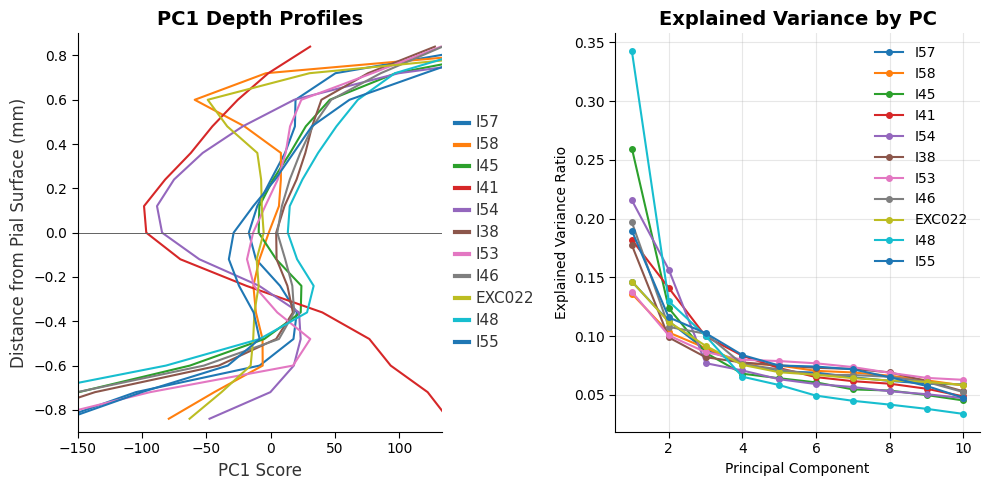

In [86]:
# %% PCA Analysis Functions

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

RESOLUTION = '120'
def perform_pca_analysis(data, plot_variance=False):
    """
    Perform PCA analysis on input data
    
    Parameters:
    -----------
    data : array-like
        Input data to perform PCA on
    plot_variance : bool
        Whether to plot explained variance ratio
        
    Returns:
    --------
    dict : Dictionary containing PCA results
        - 'pca_model': fitted PCA model
        - 'transformed_data': PCA-transformed data
        - 'explained_variance_ratio': explained variance ratio for each component
        - 'cumulative_variance': cumulative explained variance
    """
    # Convert to numpy array and handle NaN values
    data_array = np.array(data)
    data_array[np.isnan(data_array)] = 0
    
    # Fit PCA (without standardization to preserve original scale)
    pca_model = PCA()
    transformed_data = pca_model.fit_transform(data_array)
    
    # Calculate variance metrics
    explained_variance_ratio = pca_model.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    # Print results
    print(f"Data shape: {data_array.shape}")
    print(f"First 5 components explain {cumulative_variance[4]:.3f} of variance")
    print(f"PC1 explains {explained_variance_ratio[0]:.3f} of variance")
    
    # Plot if requested
    if plot_variance:
        plt.figure(figsize=(8, 5))
        plt.plot(explained_variance_ratio[:10], 'o-')  # Show first 10 components
        plt.xlabel('Principal Component')
        plt.ylabel('Explained Variance Ratio')
        plt.title('PCA Explained Variance Ratio')
        plt.grid(True, alpha=0.3)
        plt.show()
    
    return {
        'pca_model': pca_model,
        'transformed_data': transformed_data,
        'explained_variance_ratio': explained_variance_ratio,
        'cumulative_variance': cumulative_variance
    }

def reconstruct_from_pc(pca_model, transformed_data, pc_indices=[0]):
    """
    Reconstruct data using specified principal components
    
    Parameters:
    -----------
    pca_model : sklearn PCA object
        Fitted PCA model
    transformed_data : array-like
        PCA-transformed data
    pc_indices : list
        List of PC indices to use for reconstruction (default: [0] for first PC only)
        
    Returns:
    --------
    tuple : (reconstructed_data, pc_scores, pc_loadings)
    """
    # Get scores and loadings for selected PCs
    pc_scores = transformed_data[:, pc_indices]
    pc_loadings = pca_model.components_[pc_indices, :]
    
    # Reconstruct in original space
    if len(pc_indices) == 1:
        reconstructed_data = np.outer(pc_scores.flatten(), pc_loadings.flatten()) + pca_model.mean_
    else:
        reconstructed_data = np.dot(pc_scores, pc_loadings) + pca_model.mean_
    
    return reconstructed_data, pc_scores, pc_loadings

# %% Run PCA Analysis on All Subjects

def run_pca_on_all_subjects(data_storage, resolution='240'):
    """
    Run PCA analysis on all subjects in data_storage
    
    Parameters:
    -----------
    data_storage : dict
        Dictionary containing subject data
    resolution : str
        Resolution to analyze ('120' or '240')
        
    Returns:
    --------
    tuple : (all_pca_results, all_var_explained)
    """
    all_pca_results = {}
    all_var_explained = {}
    
    print(f"Running PCA analysis for {resolution}um resolution...")
    
    for subject_name in data_storage.keys():
        print(f"Processing {subject_name}...")
        
        # Get data for PCA
        data_to_pca = data_storage[subject_name][resolution]['manual']['diff_zscore']
        
        # Perform PCA
        pca_results = perform_pca_analysis(data_to_pca)
        
        # Get PC1 scores - this is the key part to check!
        reconstructed_data, pc1_scores, pc1_loadings = reconstruct_from_pc(
            pca_results['pca_model'], 
            pca_results['transformed_data']
        )
        
        # Debug: Check what we're actually storing
        print(f"  PC1 scores shape: {pc1_scores.shape}")
        print(f"  PC1 scores type: {type(pc1_scores)}")
        print(f"  PC1 scores first 5 values: {pc1_scores.flatten()[:5]}")
        
        # Store PC1 scores (flattened to 1D array)
        all_pca_results[subject_name] = pc1_scores.flatten()
        all_var_explained[subject_name] = pca_results['explained_variance_ratio']
    
    return all_pca_results, all_var_explained


def plot_depth_intensity_1d(data, dist_array, label, xlabel=None, ylabel=None, ax=None, color=None):
    """Plot depth intensity profile with clean styling"""
    # Debug: Check what data we're plotting
    print(f"  Plotting data shape: {np.array(data).shape}")
    print(f"  Data type: {type(data)}")
    print(f"  First 5 values: {np.array(data).flatten()[:5]}")
    
    # Handle 1D data properly
    if len(np.array(data).shape) == 1:
        data_mean = np.array(data)
        data_std = np.zeros_like(data_mean)  # No std for single profile
        data_sem = data_std
    else:
        data_mean = np.nanmean(data, axis=1)
        data_std = np.nanstd(data, axis=1)
        data_sem = data_std
    
    if ax is None:
        plt.figure(figsize=(4, 6))
        ax = plt.gca()
    
    dist_adj = abs(dist_array[0] - dist_array[1]) / 2
    
    # Plot with clean styling
    line = ax.plot(data_mean, dist_array[1:] + dist_adj, 
                   label=label, linewidth=1.5, color=color)
    
    # Subtle confidence interval (only if we have std)
    if np.any(data_sem > 0):
        ax.fill_betweenx(dist_array[1:] + dist_adj, 
                         data_mean - data_sem, 
                         data_mean + data_sem, 
                         alpha=0.15, color=line[0].get_color())
    
    # Clean reference line
    ax.axhline(y=0, color='#666666', linestyle='-', linewidth=0.5, alpha=0.7)
    
    # Set limits
    ax.set_xlim(np.nanpercentile(data, 2), np.nanpercentile(data, 98))
    ax.set_ylim(dist_array[-1], dist_array[0])
    
    # Minimal styling
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(0.8)
    ax.spines['bottom'].set_linewidth(0.8)
    ax.tick_params(width=0.8, length=4)
    
    if xlabel:
        ax.set_xlabel(xlabel, fontsize=12, color='#333333')
    if ylabel:
        ax.set_ylabel(ylabel, fontsize=12, color='#333333')

def plot_pca_results(all_pca_results, all_var_explained, all_dist_values, resolution='240'):
    """
    Create comprehensive PCA results visualization
    
    Parameters:
    -----------
    all_pca_results : dict
        PC1 scores for each subject
    all_var_explained : dict
        Explained variance ratios for each subject
    all_dist_values : dict
        Distance values for plotting
    resolution : str
        Resolution used for analysis
    """
    # Debug: Check what we received
    print(f"Plotting PCA results for {len(all_pca_results)} subjects")
    for subject_name, pc_scores in all_pca_results.items():
        print(f"Subject {subject_name}: PC scores shape {np.array(pc_scores).shape}")
    
    # Color palette
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', 
              '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    
    # Create combined figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    fig.patch.set_facecolor('white')
    
    # First subplot: PC1 scores depth profile
    all_pc_scores = []
    for i, subject_name in enumerate(all_pca_results.keys()): 
        pc_scores = all_pca_results[subject_name]
        subject_label = subject_name.split('_')[0]
        color = colors[i % len(colors)]
        
        print(f"Plotting {subject_name} with PC scores shape: {np.array(pc_scores).shape}")
        
        plot_depth_intensity_1d(pc_scores, all_dist_values[resolution], 
                               label=f'{subject_label}', 
                               xlabel='PC1 Score', 
                               ylabel='Distance from Pial Surface (mm)', 
                               ax=ax1, color=color)
        all_pc_scores.append(pc_scores)
    
    # Set consistent x-limits for first subplot
    vmin, vmax = np.nanpercentile(all_pc_scores, [5, 95])    
    ax1.set_xlim(vmin, vmax)
    ax1.set_title('PC1 Depth Profiles', fontsize=14, fontweight='bold')
    
    # Clean legend
    legend = ax1.legend(frameon=False, loc='center left', bbox_to_anchor=(1, 0.5), 
                       handlelength=1.0, handletextpad=0.5)
    for text in legend.get_texts():
        text.set_fontsize(11)
        text.set_color('#333333')
    for line in legend.get_lines():
        line.set_linewidth(3.0)
    
    ax1.grid(False)
    
    # Second subplot: Explained variance ratio
    for i, subject_name in enumerate(all_var_explained.keys()):
        subject_label = subject_name.split('_')[0]
        color = colors[i % len(colors)]
        # Show first 10 components
        variance_ratio = all_var_explained[subject_name][:10]
        ax2.plot(range(1, len(variance_ratio)+1), variance_ratio, 
                'o-', label=subject_label, color=color, markersize=4)
    
    ax2.set_xlabel('Principal Component')
    ax2.set_ylabel('Explained Variance Ratio')
    ax2.set_title('Explained Variance by PC', fontsize=14, fontweight='bold')
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['left'].set_linewidth(0.8)
    ax2.spines['bottom'].set_linewidth(0.8)
    ax2.tick_params(width=0.8, length=4)
    ax2.grid(True, alpha=0.3)
    ax2.legend(frameon=False, fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    return all_pc_scores






# Run the analysis
all_pca_results, all_var_explained = run_pca_on_all_subjects(data_storage, resolution=RESOLUTION)

# %% Plotting Functions
# Create the visualization
all_pc_scores = plot_pca_results(all_pca_results, all_var_explained, all_dist_values, resolution=RESOLUTION)

In [87]:
import yaspy
import numpy as np


def plot_on_brain(surface_file_path, hemi, data2plot, cmap):
    plotter = yaspy.Plotter(surface_file_path, hemi=hemi)
    vmin, vmax = np.nanpercentile(data2plot, [1,99])  # Wider range for better visualization
    abs_max =max(abs(vmin),abs(vmax))
    # set max and min of intensity_diff by percentile
    #abs_max = np.percentile(np.abs(intensity_diff_array), 95)
    #int_min = -abs_max
    #int_max = abs_max
    overlay = plotter.overlay(data2plot, cmap=cmap, vmin=-abs_max, vmax=abs_max)
    img0 = yaspy.montage([plotter.screenshot('lateral'),
                        plotter.screenshot('medial')],
                        pad=8)
    # Make the figure
    W, H = img0.size
    f, ax = plt.subplots(figsize=(6,4))  # Made figure wider
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    plt.imshow(img0)
    plt.xticks([])
    plt.yticks([])


    # Create some room in the axes for the colorbar
    ymax, ymin = plt.ylim()
    plt.ylim(ymax + 0.2 * H, ymin)
    plt.imshow(img0)
    plt.xticks([])
    plt.yticks([])
    # Inset colorbar
    cax = ax.inset_axes((0.8, 0.1, 0.18, 0.04))
    cbar = plt.colorbar(overlay, cax=cax, orientation="horizontal", label='',extend='both')
    cbar.ax.tick_params(labelsize="x-small")

cmap = 'jet'
pial_file_path = '/Users/dennis.jungchildmind.org/Desktop/BigBrain/PlosBiology2020gii/surfgii/layer3_left_327680.surf.gii'
plot_on_brain(pial_file_path, 'lh', kurtosis_120, cmap)

NameError: name 'kurtosis_120' is not defined

print(reco)